In [1]:
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
d_tr = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/train.csv', index_col='Id')
d_te = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/test.csv', index_col='Id')

In [3]:
y = d_tr.SalePrice.copy()
d_tr = d_tr.drop(columns='SalePrice').copy()

# d_tr = (1460, 80) , d_te = (1459, 79) = 2919
full = pd.concat([d_tr, d_te])#.reset_index()
# full.set_index('Id', inplace=True)

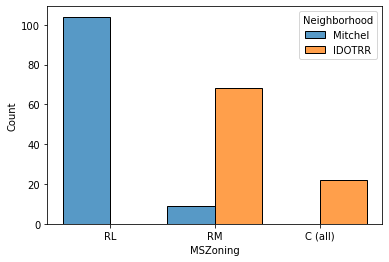

In [4]:
neighbor = ['IDOTRR', 'Mitchel']
plot_data = full[full['Neighborhood'].isin(neighbor)]

sns.histplot(data=plot_data, x='MSZoning', hue='Neighborhood', multiple='dodge', shrink=.9);

In [ ]:
full.GarageCond

In [49]:
def fillWithNone(df):
    ''' nan in 'PoolQC' means 'no pool' 
        nan in 'MiscFeature' means 'no misc feature'
        nan in 'Alley' means 'no alley acces'
        nan in 'Fence' means 'no fence'
        nan in 'FireplaceQu' means 'no Fireplace'
        nan in 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond' replaced with 'None' too
    
    recive a df
    '''
    df = df.copy()
    
    columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
               'FireplaceQu', 'GarageType', 'GarageFinish', 
               'GarageQual', 'GarageCond'
              ]
    
    for col in columns:
        df[col] = df[col].fillna('None')
    
    return df



def mszoning(df):
    ''' recives a DF this imputation takes place on test data only'''
    
    df = df.copy()
    
    idotrr = ( (df['Neighborhood'] == 'IDOTRR') & (df['MSZoning'].isna()) )
    mitchel = ( (df['Neighborhood'] == 'Mitchel') & (df['MSZoning'].isna()) )
    
    df.loc[ idotrr , 'MSZoning'] = 'RM'
    df.loc[ mitchel, 'MSZoning'] = 'RL'
    
#     # to test this function out of here
#     temp = mszoning(d_te)
#     # lable index acces at [1916, 2217, 2251, 2905
#     temp.loc[[1916, 2217, 2251, 2905], 'MSZoning']
    
    return df

def lotFrontage(df):
    ''' recives a DF the imputation takes place on both 'tr', 'te' data'''
    df = df.copy()
    
    area_vs_frontage = LinearRegression()
    
    X = df['LotArea'].values#.reshape(-1,1)
    y = df['LotFrontage'].values
    
    area_vs_frontage.fit(X, y)
    
    
    

In [ ]:
area_vs_frontage = LinearRegression()
area_vs_frontage_X = data['LotArea'].values.reshape(-1, 1)
area_vs_frontage_y = data['LotFrontage'].values
area_vs_frontage.fit(area_vs_frontage_X,area_vs_frontage_y)
for table in [df,test]:
    table['LotFrontage'].fillna(area_vs_frontage.intercept_ + 
                                table['LotArea'] * area_vs_frontage.coef_[0] 
                                , inplace=True)

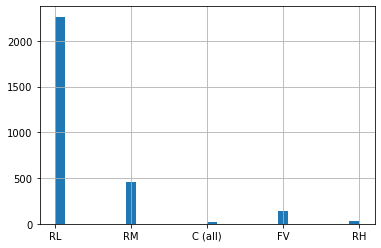

In [17]:
full.MSZoning.hist(bins=30);

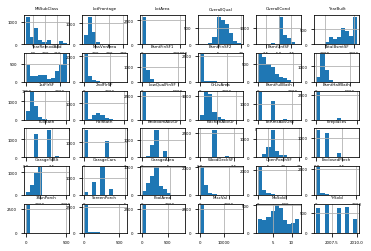

In [13]:
fig = full.hist(xlabelsize=4,ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]
plt.show()